In [1]:
import os
import random
import torch
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from collections import defaultdict
import dill
import matplotlib.pyplot as plt
from datetime import datetime
from copy import deepcopy
import torch
from torch import nn
import torch.nn.functional as F
import lovely_tensors as lt
lt.monkey_patch()

import csng
from csng.models.inverted_encoder import InvertedEncoder, InvertedEncoderBrainreader
from csng.models.ensemble import EnsembleInvEnc
from csng.models.utils.gan import init_decoder as init_gan_decoder
from csng.models.utils.cnn import init_decoder as init_cnn_decoder
from csng.models.inverted_encoder_decoder import InvertedEncoderDecoder
from csng.utils.mix import seed_all, check_if_data_zscored, update_config_paths, update_config
from csng.utils.data import standardize, normalize, crop
from csng.utils.comparison import find_best_ckpt, load_decoder_from_ckpt, plot_reconstructions, plot_metrics, eval_decoder, SavedReconstructionsDecoder, collect_all_preds_and_targets
from csng.losses import get_metrics
from csng.data import get_dataloaders, get_sample_data
from csng.brainreader_mouse.encoder import get_encoder as get_encoder_brainreader
from csng.mouse_v1.encoder import get_encoder as get_encoder_sensorium_mouse_v1
from csng.cat_v1.encoder import get_encoder as get_encoder_cat_v1
# from monkeysee.SpatialBased.decoding_wrapper import MonkeySeeDecoder

### set paths
DATA_PATH = os.environ["DATA_PATH"]
DATA_PATH_CAT_V1 = os.path.join(DATA_PATH, "cat_V1_spiking_model", "50K_single_trial_dataset")
DATA_PATH_MOUSE_V1 = os.path.join(DATA_PATH, "mouse_v1_sensorium22")
DATA_PATH_BRAINREADER = os.path.join(DATA_PATH, "brainreader")

print(f"{DATA_PATH=}")
print(f"{DATA_PATH_CAT_V1=}")
print(f"{DATA_PATH_MOUSE_V1=}")
print(f"{DATA_PATH_BRAINREADER=}")

DATA_PATH='/media/jan/ext_ssd/csng_data'
DATA_PATH_CAT_V1='/media/jan/ext_ssd/csng_data/cat_V1_spiking_model/50K_single_trial_dataset'
DATA_PATH_MOUSE_V1='/media/jan/ext_ssd/csng_data/mouse_v1_sensorium22'
DATA_PATH_BRAINREADER='/media/jan/ext_ssd/csng_data/brainreader'


## Plot performance vs. number of neurons/datapoints

### Load

In [4]:
to_load = [
    ### amount of data
    "../../results/12-04-25/brainreader_data/2025-04-22_19-10-53.pt",
    "../../results/12-04-25/sens22_data/2025-04-22_19-23-12.pt",
    "../../results/12-04-25/catv1_data/2025-04-22_18-56-34.pt",

    ### number of neurons
    # "results/12-04-25/brainreader_neurons/2025-04-22_18-03-03.pt",
    # "results/12-04-25/sens22_neurons/2025-04-22_18-38-45.pt",
    # "results/12-04-25/catv1_neurons/2025-04-22_18-26-42.pt",

    # "../../results/12-04-25/brainreader_neurons_rounded/2025-04-25_19-30-44.pt",
    # "../../results/12-04-25/sens22_neurons_rounded/2025-04-25_19-00-45.pt",
    # "../../results/12-04-25/catv1_neurons_rounded/2025-04-25_20-29-05.pt",
]

runs, runs_cfg = {}, {}
for path in to_load:
    path_file_name = os.path.basename(path)
    runs_ckpt = torch.load(path, pickle_module=dill)
    _runs, _runs_cfg = runs_ckpt["runs"], runs_ckpt["config"]
    for run_name, run_dict in _runs.items():
        if run_name in runs:
            run_name = f"{run_name}__{path_file_name}"
        runs[run_name] = run_dict
        _runs_cfg[run_name] = _runs_cfg

print("Loaded runs:")
for method_name, results in runs.items():
    print(f"  {method_name}: {list(results.keys())}")

Loaded runs:
  GAN (4500): ['run_name', 'ckpt_path', 'test_losses', 'configs', 'histories', 'best_val_losses', 'stim_pred_best', 'ckpt_paths']
  GAN (3000): ['run_name', 'ckpt_path', 'test_losses', 'configs', 'histories', 'best_val_losses', 'stim_pred_best', 'ckpt_paths']
  GAN (2000): ['run_name', 'ckpt_path', 'test_losses', 'configs', 'histories', 'best_val_losses', 'stim_pred_best', 'ckpt_paths']
  GAN (1000): ['run_name', 'ckpt_path', 'test_losses', 'configs', 'histories', 'best_val_losses', 'stim_pred_best', 'ckpt_paths']
  GAN (500): ['run_name', 'ckpt_path', 'test_losses', 'configs', 'histories', 'best_val_losses', 'stim_pred_best', 'ckpt_paths']
  GAN (100): ['run_name', 'ckpt_path', 'test_losses', 'configs', 'histories', 'best_val_losses', 'stim_pred_best', 'ckpt_paths']
  GAN (4473): ['run_name', 'ckpt_path', 'test_losses', 'configs', 'histories', 'best_val_losses', 'stim_pred_best', 'ckpt_paths']
  GAN (3000)__2025-04-22_19-23-12.pt: ['run_name', 'ckpt_path', 'test_losses', 

## Plot losses

In [5]:
def collect_x_y(runs, to_plot):
    ### collect x and y values and reconstructions
    xs, x_tick_labels, ys, ys_stds = [], [], defaultdict(list), defaultdict(list)
    recons = []

    for method_name, plot_info in to_plot.items():
        xs.append(plot_info["x"])
        x_tick_labels.append(plot_info.get("label", plot_info["x"]))
        for loss_name, loss in runs[method_name]["test_losses"][0]["total"].items():
            losses = [loss]
            if "other_seeds" in plot_info:
                for other_seed_run_name in plot_info["other_seeds"]:
                    losses.append(runs[other_seed_run_name]["test_losses"][0]["total"][loss_name])
            ys[loss_name].append(np.mean(losses))
            ys_stds[loss_name].append(np.std(losses))

        ### validation loss
        ys["val_loss"].append(np.mean([runs[mname]["best_val_losses"][0] for mname in [method_name, *plot_info.get("other_seeds", [])]]))
        ys_stds["val_loss"].append(np.std([runs[mname]["best_val_losses"][0] for mname in [method_name, *plot_info.get("other_seeds", [])]]))
    
        ### reconstructions
        recons.append(runs[method_name]["stim_pred_best"][0])

    ### sort by x
    xs, ys, ys_stds = np.array(xs), {k: np.array(v) for k, v in ys.items()}, {k: np.array(v) for k, v in ys_stds.items()}
    x_tick_labels = np.array(x_tick_labels)
    sort_idx = np.argsort(xs)
    xs, ys, ys_stds = xs[sort_idx], {k: v[sort_idx] for k, v in ys.items()}, {k: v[sort_idx] for k, v in ys_stds.items()}
    x_tick_labels = x_tick_labels[sort_idx]
    recons = [recons[i] for i in sort_idx]

    return xs, x_tick_labels, ys, ys_stds, recons

In [6]:
### plotting config
to_plot = {
    ### amount of data
    "Brainreader": {
        "GAN (4500)": {"x": 4500},
        "GAN (3000)": {"x": 3000},
        "GAN (2000)": {"x": 2000},
        "GAN (1000)": {"x": 1000},
        "GAN (500)": {"x": 500},
        "GAN (100)": {"x": 100},
    },
    "SENSORIUM 2022": {
        "GAN (4473)": {"x": 4473},
        "GAN (3000)__2025-04-22_19-23-12.pt": {"x": 3000},
        "GAN (2000)__2025-04-22_19-23-12.pt": {"x": 2000},
        "GAN (1000)__2025-04-22_19-23-12.pt": {"x": 1000},
        "GAN (500)__2025-04-22_19-23-12.pt": {"x": 500},
        "GAN (100)__2025-04-22_19-23-12.pt": {"x": 100},
    },
    "Cat V1": {
        # "GAN (45000)": {"x": 45000},
        "GAN (5000)": {"x": 5000},
        "GAN (4000)": {"x": 4000},
        "GAN (3000)__2025-04-22_18-56-34.pt": {"x": 3000},
        "GAN (2000)__2025-04-22_18-56-34.pt": {"x": 2000},
        "GAN (1000)__2025-04-22_18-56-34.pt": {"x": 1000},
        "GAN (500)__2025-04-22_18-56-34.pt": {"x": 500},
        "GAN (100)__2025-04-22_18-56-34.pt": {"x": 100},
    },

    ### number of neurons
    # "Brainreader": {
    #     "GAN (100%)": {"x": (max_neurons := 8587)},
    #     "GAN (75%)": {"x": int(0.75*max_neurons)},
    #     "GAN (50%)": {"x": int(0.5*max_neurons)},
    #     "GAN (25%)": {"x": int(0.25*max_neurons)},
    #     "GAN (10%)": {"x": int(0.1*max_neurons)},
    #     "GAN (5%)": {"x": int(0.05*max_neurons)},
    #     "GAN (2.5%)": {"x": int(0.025*max_neurons)},
    #     "GAN (1.5%)": {"x": int(0.015*max_neurons)},
    #     "GAN (1%)": {"x": int(0.01*max_neurons)},
        
    #     # "GAN (100)": {"x": 100},
    #     # "GAN (500)": {"x": 500},
    #     # "GAN (1000)": {"x": 1000},
    #     # "GAN (2500)": {"x": 2500},
    #     # "GAN (5000)": {"x": 5000},
    #     # "GAN (8000)": {"x": 8000},
    # },
    # "SENSORIUM 2022": {
    #     "GAN (100%)__2025-04-25_19-00-45.pt": {"x": (max_neurons := 8372)},
    #     "GAN (75%)__2025-04-25_19-00-45.pt": {"x": int(0.75*max_neurons)},
    #     "GAN (50%)__2025-04-25_19-00-45.pt": {"x": int(0.5*max_neurons)},
    #     "GAN (25%)__2025-04-25_19-00-45.pt": {"x": int(0.25*max_neurons)},
    #     "GAN (10%)__2025-04-25_19-00-45.pt": {"x": int(0.1*max_neurons)},
    #     "GAN (5%)__2025-04-25_19-00-45.pt": {"x": int(0.05*max_neurons)},
    #     "GAN (2.5%)__2025-04-25_19-00-45.pt": {"x": int(0.025*max_neurons)},
    #     "GAN (1.5%)__2025-04-25_19-00-45.pt": {"x": int(0.015*max_neurons)},
    #     "GAN (1%)__2025-04-25_19-00-45.pt": {"x": int(0.01*max_neurons)},

    #     # "GAN (100)__2025-04-25_19-00-45.pt": {"x": 100},
    #     # "GAN (500)__2025-04-25_19-00-45.pt": {"x": 500},
    #     # "GAN (1000)__2025-04-25_19-00-45.pt": {"x": 1000},
    #     # "GAN (2500)__2025-04-25_19-00-45.pt": {"x": 2500},
    #     # "GAN (5000)__2025-04-25_19-00-45.pt": {"x": 5000},
    #     # "GAN (8000)__2025-04-25_19-00-45.pt": {"x": 8000},
    # },
    # "Cat V1": {
    #     # "GAN (100%)__2025-04-25_20-29-05.pt": {"x": (max_neurons := 46875)},
    #     "GAN (75%)__2025-04-25_20-29-05.pt": {"x": int(0.75*(max_neurons := 46875))},
    #     # "GAN (50%)__2025-04-25_20-29-05.pt": {"x": int(0.5*max_neurons)},
    #     # "GAN (25%)__2025-04-25_20-29-05.pt": {"x": int(0.25*max_neurons)},
    #     # "GAN (8000 neurons)": {"x": int(8000)},
    #     # "GAN (10%)__2025-04-25_20-29-05.pt": {"x": int(0.1*max_neurons)},
    #     # "GAN (5%)__2025-04-25_20-29-05.pt": {"x": int(0.05*max_neurons)},
    #     "GAN (2.5%)__2025-04-25_20-29-05.pt": {"x": int(0.025*max_neurons)},
    #     # "GAN (1%)__2025-04-25_20-29-05.pt": {"x": int(0.01*max_neurons)},
    #     # "GAN (0.1%)": {"x": int(0.001*max_neurons)},

    #     "GAN (100 neurons)": {"x": 100},
    #     "GAN (500 neurons)": {"x": 500},
    #     # "GAN (1000 neurons)": {"x": 1000},
    #     "GAN (2500 neurons)": {"x": 2500},
    #     "GAN (5000 neurons)": {"x": 5000},
    #     "GAN (8000 neurons)": {"x": 8000},
    # },
}

In [7]:
### collect
results = {}
for dataset_name, plot_info in to_plot.items():
    results[dataset_name] = {}
    xs, x_tick_labels, ys, ys_stds, recons = collect_x_y(runs, plot_info)
    results[dataset_name]["xs"] = xs
    results[dataset_name]["x_tick_labels"] = x_tick_labels
    results[dataset_name]["ys"] = ys
    results[dataset_name]["ys_stds"] = ys_stds
    results[dataset_name]["recons"] = recons
    print(f"Collected results for {dataset_name}  |  xs: {xs}")

Collected results for Brainreader  |  xs: [ 100  500 1000 2000 3000 4500]
Collected results for SENSORIUM 2022  |  xs: [ 100  500 1000 2000 3000 4473]
Collected results for Cat V1  |  xs: [ 100  500 1000 2000 3000 4000 5000]


#### Line plot

In [47]:
# Plotting config
# plot_loss = "Alex(5)" # Alex(2)
plot_loss = "PixCorr"
x_label = "# of data points" # for data
# x_label = "# of neurons" # for neurons
ticks_fontsize = 17  # Font size for ticks
label_fontsize = 17  # Font size for labels
output_dir = None
# os.makedirs((output_dir := "plots/neurons_full"), exist_ok=True)
# os.makedirs((output_dir := "/home/jan/Desktop/Dev/csng/decoding-brain-activity/publication/figures_12-04-25/neurons_full"), exist_ok=True)

# x_ticks_to_show = [0, 2500, 5000, 7500, 10000] # for neurons
# y_ticks_to_show = [0.6, 0.8, 1.0] # Alex(2)
# y_ticks_to_show = [-0.2, 0.3, 0.8] # PixCorr
# y_ticks_to_show = [0.2, 0.5, 0.8] # PixCorr
# max_x = None
# scale_log_x = True

# y_ticks_to_show = [0.5, 0.8, 1.0] # Alex(2)
y_ticks_to_show = [-0.2, 0.3, 0.8] # PixCorr
x_ticks_to_show = [0, 2500, 5000] # for data
max_x = 6000
scale_log_x = False

show_second_best_at = None
# show_second_best_at = 0.924 # InvEnc Alex(2) M-1
show_second_best_at = .495 # InvEnc PixCorr M-1
# show_second_best_at = .612 # InvEnc PixCorr B-6
# show_second_best_at = .990 # InvEnc Alex(2) B-6

# show_second_best_at = .813 # MindEye2 (FT) Alex(5) M-1
# show_second_best_at = .892 # MindEye2 (FT) Alex(5) B-6

In [41]:
# Set publication plot style
plt.style.use('seaborn-v0_8-whitegrid')  # Clean and professional style
plt.rcParams.update({
    # 'font.family': 'Arial',  # Standard font for publications
    'font.size': ticks_fontsize,
    'axes.linewidth': 1.2,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'figure.dpi': 300,  # High resolution for publication
    'savefig.dpi': 300,
    'axes.titlesize': label_fontsize,
    'axes.labelsize': label_fontsize,
    'xtick.labelsize': ticks_fontsize,
    'ytick.labelsize': ticks_fontsize,
    'legend.fontsize': ticks_fontsize,
    'figure.autolayout': True,
})

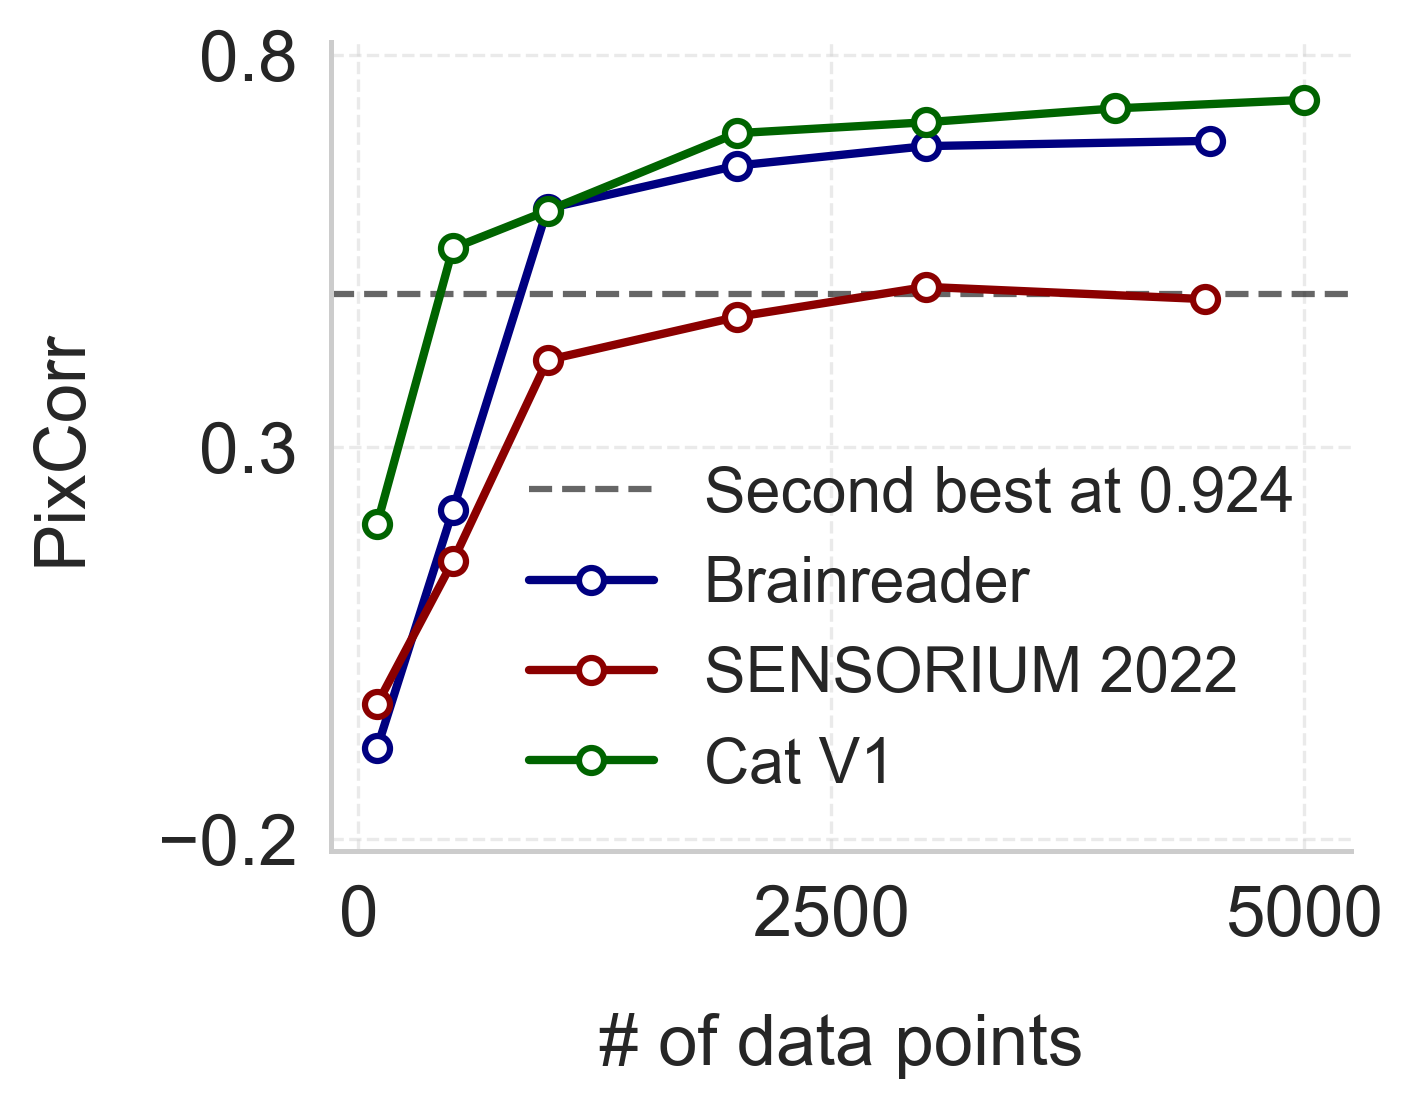

In [48]:
# Create figure
fig, ax = plt.subplots(figsize=(5, 4))  # Compact size for publications
if show_second_best_at is not None:
    ax.axhline(y=show_second_best_at, xmin=0, xmax=1, color='black', linestyle='--', linewidth=1.5, alpha=0.6, label='Second best at 0.924')

# Colors for different datasets (extendable for more datasets)
colors = ['navy', 'darkred', 'darkgreen', 'purple', 'orange']  # Add more colors if needed
dataset_names = list(results.keys())

# Track min/max y-values across all datasets for y-axis limits
all_mean_values = []
all_std_values = []

# Plot a line for each dataset
for idx, dataset_name in enumerate(dataset_names):
    if idx >= len(colors):
        print(f"Warning: Not enough colors for dataset {dataset_name}. Using default color.")
        color = 'gray'
    else:
        color = colors[idx]

    # Bound data by max_x
    xs_bounded, ys_bounded, ys_stds_bounded = [], defaultdict(list), defaultdict(list)
    xs = results[dataset_name]["xs"]
    ys = results[dataset_name]["ys"]
    ys_stds = results[dataset_name]["ys_stds"]

    for x in xs:
        if max_x is None or x <= max_x:
            xs_bounded.append(x)
            for loss_name in ys.keys():
                xs_idx = np.where(xs == x)[0][0]
                ys_bounded[loss_name].append(ys[loss_name][xs_idx])
                ys_stds_bounded[loss_name].append(ys_stds[loss_name][xs_idx])
            ys_bounded["val_loss"].append(ys["val_loss"][xs_idx])
            ys_stds_bounded["val_loss"].append(ys_stds["val_loss"][xs_idx])

    mean_values = ys_bounded[plot_loss]
    std_values = ys_stds_bounded[plot_loss]

    # Plot line with error bars
    # ax.errorbar(
    #     xs_bounded, mean_values, yerr=std_values, fmt='-o',
    #     capsize=4, capthick=1.5, elinewidth=1.5, markersize=6,
    #     color=color, ecolor='gray', linewidth=2, markerfacecolor='white',
    #     markeredgewidth=1.5, label=dataset_name
    # )
    # Show without error bars
    ax.plot(
        xs_bounded, mean_values, '-o',
        color=color, linewidth=2, markersize=6,
        markerfacecolor='white', markeredgewidth=1.5,
        label=dataset_name
    )

    # Collect min/max for y-axis limits
    all_mean_values.extend(mean_values)
    all_std_values.extend(std_values)

# Customize
ax.set_xticks(x_ticks_to_show)
ax.set_xticklabels(x_ticks_to_show, fontsize=ticks_fontsize)
ax.grid(True, which='major', linestyle='--', alpha=0.4)
ax.tick_params(axis='both', which='major', pad=8)

# Customize y-axis ticks
if y_ticks_to_show is not None:
    ax.set_yticks(y_ticks_to_show)
else:
    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=4))

# Set axis labels
ax.set_xlabel(x_label, fontsize=label_fontsize, labelpad=15)
ax.set_ylabel(plot_loss, fontsize=label_fontsize, labelpad=15)

# Ensure y-axis starts at 0 if appropriate
if y_ticks_to_show[0] > 0:
    ax.set_ylim(y_ticks_to_show[0] * 0.98, y_ticks_to_show[-1] * 1.02)  # Add padding
else:
    ax.set_ylim(y_ticks_to_show[0] * 1.08, y_ticks_to_show[-1] * 1.02)  # Add padding
if scale_log_x:
    ax.set_xscale('log')

# Add legend
ax.legend(fontsize=ticks_fontsize - 2, frameon=False)

# Remove top and right spines
sns.despine(ax=ax, top=True, right=True)

# Tight layout to prevent label cutoff
plt.tight_layout()

# Save the plot
if output_dir is not None:
    output_path = os.path.join(output_dir, f'decoder_performance_{plot_loss.replace(" ", "_").replace("(", "").replace(")", "")}.png')
    plt.savefig(output_path, format='png', bbox_inches='tight', dpi=300)
    plt.savefig(output_path.replace('.png', '.pdf'), format='pdf', bbox_inches='tight', dpi=300)  # Save as PDF for publications
    print(f"Plot saved to {output_path} and {output_path.replace('.png', '.pdf')}")
plt.show()  # Show the plot (optional, can be commented out if not needed)
plt.close()

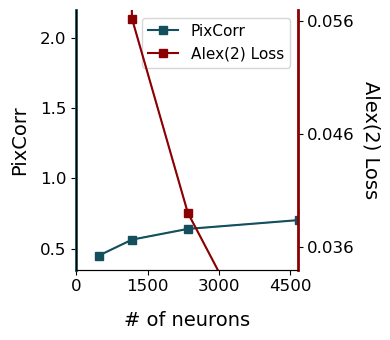

In [20]:
### line plot
to_plot_label = plot_loss
if plot_loss == "PL":
    to_plot_label = "Perceptual loss"

c1 = "#134f5cff"
c2 = "darkred"
# c = "tab:blue"

fig, ax = plt.subplots(ncols=1, figsize=(4, 3.5))
# fig, ax = plt.subplots(ncols=1, figsize=(6., 4))
ax.plot(xs, ys[plot_loss], marker="s", color=c1, label=plot_loss)
ax.fill_between(xs, np.array(ys[plot_loss]) - np.array(ys_stds[plot_loss]), np.array(ys[plot_loss]) + np.array(ys_stds[plot_loss]), color=c1, alpha=0.2)

### x axis
# ax.set_xlim(0, 8800)
# ax.set_xticks([0, 2500, 5000, 7500])
ax.set_xlim(0, 4650)
ax.set_xticks([0, 1500, 3000, 4500])
# ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=3, min_n_ticks=2))
ax.set_xticklabels(ax.get_xticks(), fontsize=ticks_fontsize)
ax.set_xlabel(x_label, labelpad=12, fontsize=label_fontsize)

### y axis
# ax.set_ylim(0.3-0.05, 0.75+0.05)
# ax.set_yticks([0.3, 0.45, 0.6, 0.75])
# ax.set_yticks([0.3, 0.6, 0.9])
ax.set_ylim(0.35, 2.2)
ax.set_yticks([0.5, 1, 1.5, 2])
# ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, min_n_ticks=2))
ax.set_yticklabels(ax.get_yticks(), fontsize=ticks_fontsize)
ax.set_ylabel(to_plot_label, labelpad=8, fontsize=label_fontsize)

### second y axis
if plot_loss_2 is not None:
    ax2 = ax.twinx()

    ax2.set_yticks([0.035, 0.038, 0.041])
    ax2.set_ylim([0.034, 0.057])
    # ax2.set_ylim([0.036, 0.057])
    ax2.set_yticks([0.036, 0.046, 0.056])
    ax2.spines["right"].set_color(c2)
    ax2.spines["right"].set_linewidth(2)
    ax2.spines["top"].set_visible(False)
    ax2.plot(xs, ys[plot_loss_2], marker="s", color=c2, label=plot_loss_2)
    ax2.fill_between(xs, np.array(ys[plot_loss_2]) - np.array(ys_stds[plot_loss_2]), np.array(ys[plot_loss_2]) + np.array(ys_stds[plot_loss_2]), color=c2, alpha=0.2)
    ax2.set_yticklabels(ax2.get_yticks(), fontsize=ticks_fontsize)
    ax2.set_ylabel(plot_loss_2, labelpad=18, fontsize=label_fontsize)
    ## rotate y label
    ax2.yaxis.label.set_rotation(270)

    ax.spines["left"].set_linewidth(2)
    ax.spines["left"].set_color(c1)

### add legend(s)
ax.legend(loc="upper left", fontsize=12)
# if plot_loss_2 is not None:
#     ax2.legend(loc="upper left", fontsize=12)
### combine legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc="upper right", fontsize=label_fontsize-3)


### general
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
# os.makedirs("results/__figures__", exist_ok=True)
# fig_name = f"results/__figures__/line_{x_label.lower().replace(' ', '-')}.pdf"
# fig.savefig(fig_name, bbox_inches="tight")
# print(f"Saved to: {fig_name}")

#### Bar plot

In [21]:
plot_loss = "FID"
plot_loss_2 = "MSE"
x_label = "Training data"
c1 = "#134f5cff"
c2 = "darkred"
ticks_fontsize = 12
label_fontsize = 14

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

to_plot_label = plot_loss
if plot_loss == "PL":
    to_plot_label = "Perceptual loss"

# fig, ax = plt.subplots(ncols=1, figsize=(6., 4.2))
fig, ax = plt.subplots(ncols=1, figsize=(6., 8.2))
# fig, ax = plt.subplots(ncols=1, figsize=(5, 5))

# Bar width and offsets
bar_width = 0.35
x_positions = np.arange(len(x_tick_labels))

# Plot first set of bars
ax.bar(x_positions - bar_width / 2, ys[plot_loss], bar_width, color=c1, label=to_plot_label)
# Add error bars for the first set
for i, (x, y) in enumerate(zip(x_positions, ys[plot_loss])):
    ax.errorbar(x - bar_width / 2, y, yerr=ys_stds[plot_loss][i], fmt="o", color="black", capsize=5)

# Create a secondary y-axis for the second set of bars
if plot_loss_2 is not None:
    ax2 = ax.twinx()
    ax2.bar(x_positions + bar_width / 2, ys[plot_loss_2], bar_width, color=c2, label=plot_loss_2)
    # Add error bars for the second set
    for i, (x, y) in enumerate(zip(x_positions, ys[plot_loss_2])):
        ax2.errorbar(x + bar_width / 2, y, yerr=ys_stds[plot_loss_2][i], fmt="o", color="black", capsize=5)

    # Configure secondary y-axis
    # ax2.set_ylim(0., 0.043)
    # ax2.set_yticks([0., 0.02, 0.04])
    ax2.set_ylabel(plot_loss_2, labelpad=18, fontsize=label_fontsize)
    ax2.tick_params(axis='y', labelsize=ticks_fontsize)
    ax2.yaxis.label.set_rotation(270)
    ax2.spines["right"].set_color(c2)
    ax2.spines["right"].set_linewidth(2)
    ax2.spines["top"].set_visible(False)
    ax.spines["left"].set_linewidth(2)
    ax.spines["left"].set_color(c1)


# Configure x-axis
ax.set_xticks(x_positions)
ax.set_xticklabels(x_tick_labels, fontsize=ticks_fontsize, rotation=45, ha="right")
ax.set_xlabel(x_label, labelpad=12, fontsize=label_fontsize)

# Configure primary y-axis
# ax.set_ylim(0., 1.3)
# ax.set_yticks([0., 0.5, 1])
# ax.set_yticklabels(ax.get_yticks(), fontsize=ticks_fontsize)
ax.set_ylabel(to_plot_label, labelpad=12, fontsize=label_fontsize)
ax.tick_params(axis='y', labelsize=ticks_fontsize)

# Configure a single legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# ax.legend(lines + lines2, labels + labels2, loc=(0.16, 1.05), ncol=2, fontsize=label_fontsize)


# Adjust general appearance
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
os.makedirs("results/__figures__", exist_ok=True)
fig_name = f"results/__figures__/bar_{x_label.lower().replace(' ', '-')}.pdf"
fig.savefig(fig_name, bbox_inches="tight")
print(f"Saved to: {fig_name}")
